# Training the Model

## 1. Imports

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
from tqdm import tqdm

import monai
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    Resized,
    Rotate90d,
    ScaleIntensityd,
)


### 1.1 Set Environment Variables for GPU

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

### 1.2 Get Stored Dictionaries from CreateDataset

In [3]:
%store -r dictionary_train
%store -r dictionary_valid
%store -r dictionary_test

## 2. MONAI Dataloader

### 2.1 Data Transforms

In [4]:
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,128,128,128))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,128,128,128))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data


#### 2.1.1 Set Training and Validation Transforms

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["Flair_Image", "Flair_Mask_Image"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["Flair_Image", "Flair_Mask_Image"]),
        Orientationd(keys=["Flair_Image", "Flair_Mask_Image"], axcodes="RAS"),        
        EnsureTyped(keys=["Flair_Image", "Flair_Mask_Image"]),
        Resized(keys=["Flair_Image", "Flair_Mask_Image"], spatial_size=(128,128,128)),
        MakeSingleVolumed(keys=["Flair_Image", "Flair_Mask_Image"]),
        Rotate90d(keys=["Flair_Image", "Flair_Mask_Image"]),
        ScaleIntensityd(keys=["Flair_Image", "Flair_Mask_Image"])
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["Flair_Image", "Flair_Mask_Image"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["Flair_Image", "Flair_Mask_Image"]),
        Orientationd(keys=["Flair_Image", "Flair_Mask_Image"], axcodes="RAS"),        
        EnsureTyped(keys=["Flair_Image", "Flair_Mask_Image"]),
        Resized(keys=["Flair_Image", "Flair_Mask_Image"], spatial_size=(128,128,128)),
        MakeSingleVolumed(keys=["Flair_Image", "Flair_Mask_Image"]),
        Rotate90d(keys=["Flair_Image", "Flair_Mask_Image"]),
        ScaleIntensityd(keys=["Flair_Image", "Flair_Mask_Image"])
    ]
)

#### 2.1.2 Test the Transforms


In [6]:
val_files = dictionary_valid[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

here1
here2
here3
1350 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Pre/00394/NIFTI_Native/flair.nii.gz']


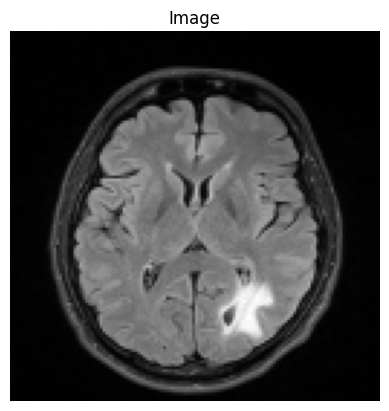

here2
here3
1351 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Pre/00346/NIFTI_Native/flair.nii.gz']


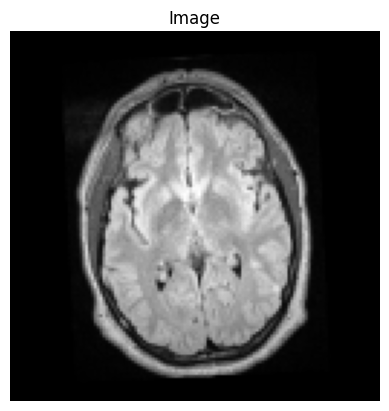

here2
here3
1352 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Atlas_Concatenated/AVAglio/Flair/AVAglio-flair_3710.nii.gz']


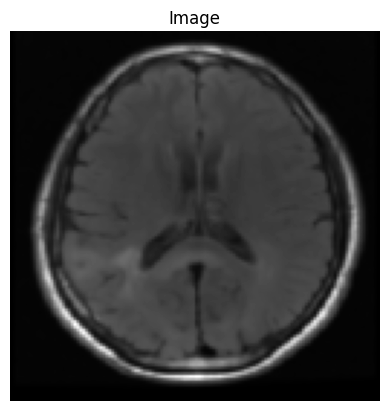

here2
here3
1353 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Post/00815/NIFTI_Native/flair.nii.gz']


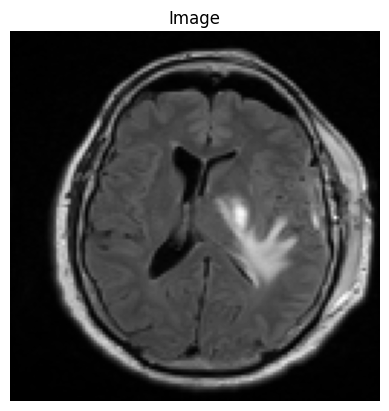

here2
here3
1354 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Atlas_Concatenated/AVAglio/Flair/AVAglio-flair_6954.nii.gz']


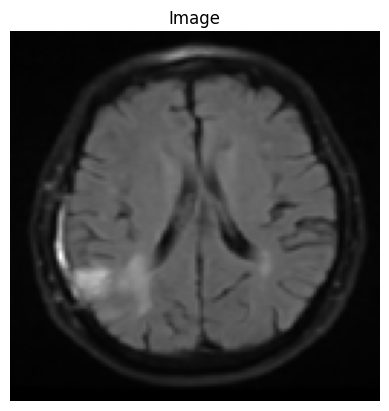

here2
here3
1355 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Pre/03067/NIFTI_Native/flair.nii.gz']


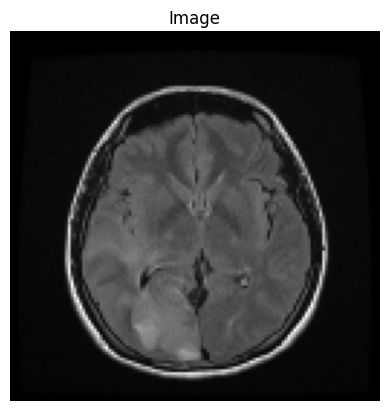

here2
here3
1356 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Post/00390/NIFTI_Native/flair.nii.gz']


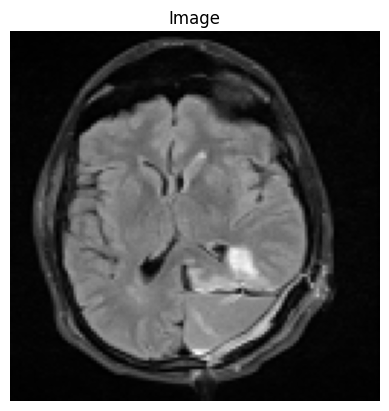

here2
here3
1357 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Post/01306/NIFTI_Native/flair.nii.gz']


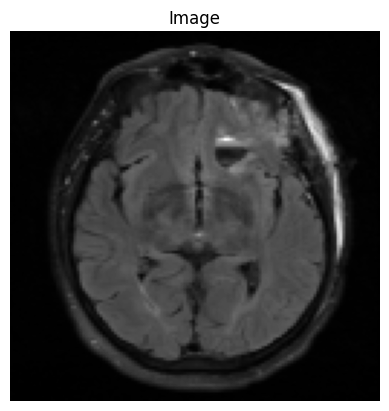

here2
here3
1358 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Post/01450/NIFTI_Native/flair.nii.gz']


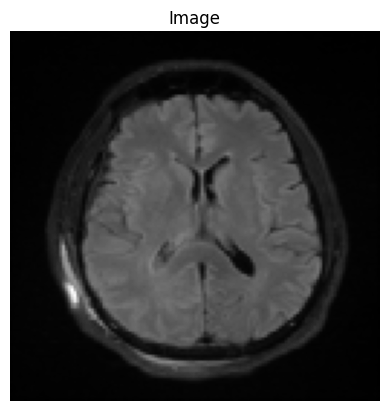

here2
here3
1359 - input_images shape: torch.Size([1, 1, 128, 128, 128])
Path - ['/trials/Ivy_Foundation/Final_for_Distribution/Post/02451/NIFTI_Native/flair.nii.gz']


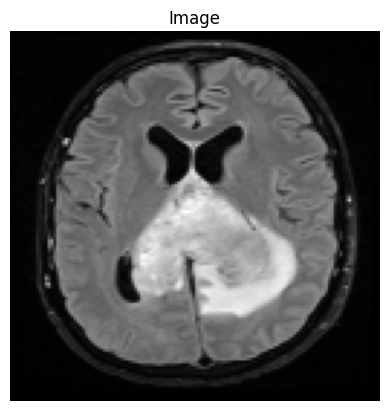

It has been 9.2757248878479 seconds since the loop started


In [7]:
program_starts = time()
step = 1350
print('here1')
for item in check_DataLoader:
    print('here2')
    input_images, label, path= (item["Flair_Image"], item["MGMT"], item["Flair_Path"])
    print('here3')
    try:
        print(f"{step} - input_images shape: {input_images.shape}")
        print(f"Path - {path}")
        plt.title("Image")
        plt.axis('off')
        plt.imshow(np.squeeze(input_images[0,0,:,:,64]), cmap="gray")
        plt.show()
    except:
        print(' ERROR !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

## 2.2 Create Train/Valid/Test DataLoaders

In [8]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=os.cpu_count())

valid_ds = CacheDataset(data=dictionary_valid, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_ds, batch_size=4, shuffle=False, num_workers=os.cpu_count())

test_ds = CacheDataset(data=dictionary_test, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=os.cpu_count())

20


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:29<00:00,  4.28it/s]


## 3. ResNet 101 Model (for now)

### 3.1 Model and Device Setup


In [9]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = monai.networks.nets.resnet.resnet101(spatial_dims=3, n_input_channels=2, num_classes=2)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)
model.to(device)

# Loss function for each output
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-5)

cuda
Let's use 4 GPUs!


#### 3.1.1 Helper Function to Visualize Training Curves

In [10]:
def plot_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure("train", (12, 12))

    plt.subplot(2, 1, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(train_loss))]
    y = train_loss
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [i + 1 for i in range(len(val_loss))]
    y = val_loss
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))


    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    x = [(i + 1) for i in range(len(train_acc))]
    y = train_acc
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [(i + 1) for i in range(len(val_acc))]
    y = val_acc
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))
    
    plt.show()

### 3.2 Training

In [11]:
post_pred = Compose([Activations(softmax=True)])
post_label = Compose([AsDiscrete(to_onehot=2)])

----------
epoch 1/10


Epoch : 100%|█████████████████████████████████████████████████████████████████████████| 251/251 [03:15<00:00,  1.29it/s, Overall Training Loss=0.625]


saved new best metric model
current epoch: 1 current avg accuracy: 0.5680 best accuracy: 0.5680 at epoch 1
train accuracy: 0.5737 validation accuracy: 0.5680 train loss: 0.6819 validation loss 0.7015
----------
epoch 2/10


Epoch : 100%|█████████████████████████████████████████████████████████████████████████| 251/251 [03:22<00:00,  1.24it/s, Overall Training Loss=0.699]


current epoch: 2 current avg accuracy: 0.5680 best accuracy: 0.5680 at epoch 1
train accuracy: 0.5767 validation accuracy: 0.5680 train loss: 0.6833 validation loss 0.6950
----------
epoch 3/10


Epoch : 100%|█████████████████████████████████████████████████████████████████████████| 251/251 [03:25<00:00,  1.22it/s, Overall Training Loss=0.659]


current epoch: 3 current avg accuracy: 0.5600 best accuracy: 0.5680 at epoch 1
train accuracy: 0.5926 validation accuracy: 0.5600 train loss: 0.6759 validation loss 0.6969
----------
epoch 4/10


Epoch : 100%|█████████████████████████████████████████████████████████████████████████| 251/251 [03:26<00:00,  1.22it/s, Overall Training Loss=0.668]


saved new best metric model
current epoch: 4 current avg accuracy: 0.5840 best accuracy: 0.5840 at epoch 4
train accuracy: 0.5747 validation accuracy: 0.5840 train loss: 0.6750 validation loss 0.7215
----------
epoch 5/10


Epoch : 100%|█████████████████████████████████████████████████████████████████████████| 251/251 [03:26<00:00,  1.22it/s, Overall Training Loss=0.559]


current epoch: 5 current avg accuracy: 0.5600 best accuracy: 0.5840 at epoch 4
train accuracy: 0.5926 validation accuracy: 0.5600 train loss: 0.6703 validation loss 0.7148


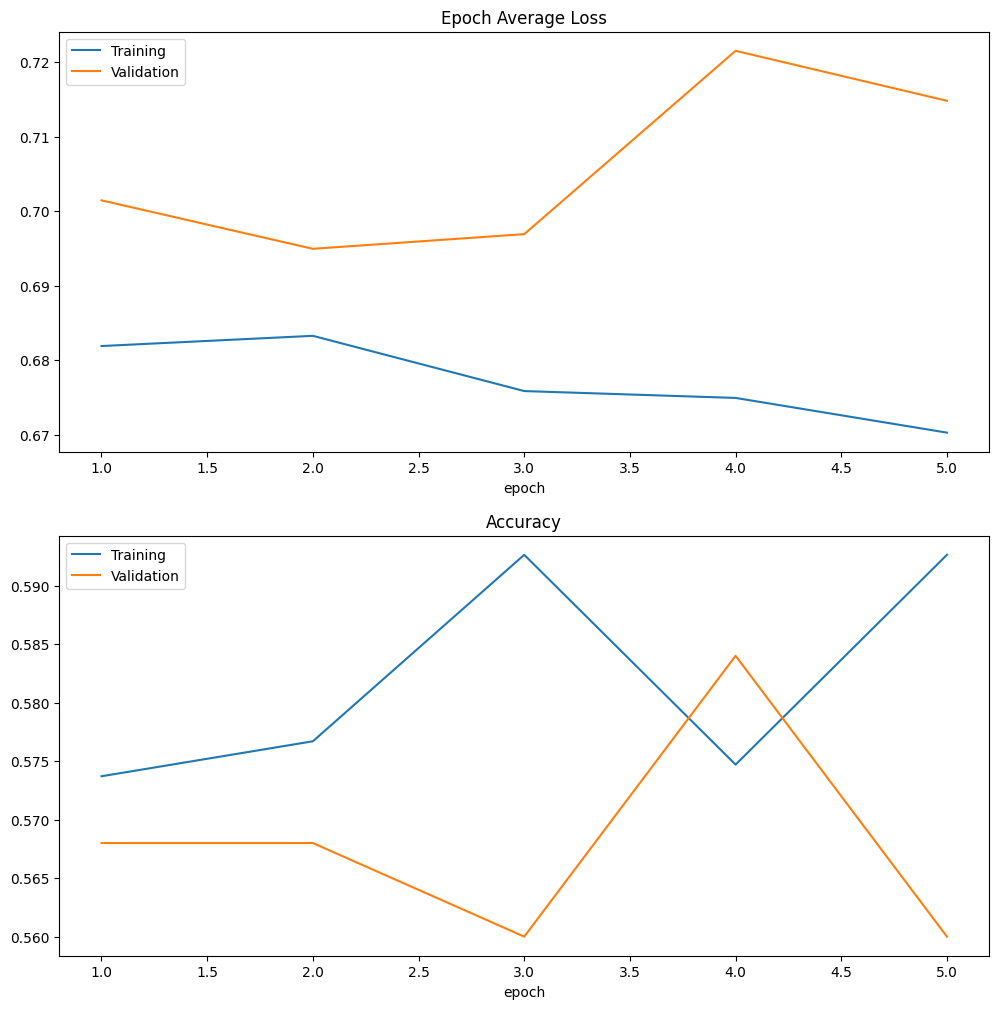

----------
epoch 6/10


Epoch : 100%|█████████████████████████████████████████████████████████████████████████| 251/251 [03:27<00:00,  1.21it/s, Overall Training Loss=0.471]


current epoch: 6 current avg accuracy: 0.5840 best accuracy: 0.5840 at epoch 4
train accuracy: 0.6135 validation accuracy: 0.5840 train loss: 0.6599 validation loss 0.7239
----------
epoch 7/10


Epoch : 100%|█████████████████████████████████████████████████████████████████████████| 251/251 [03:28<00:00,  1.20it/s, Overall Training Loss=0.575]


current epoch: 7 current avg accuracy: 0.4960 best accuracy: 0.5840 at epoch 4
train accuracy: 0.6195 validation accuracy: 0.4960 train loss: 0.6611 validation loss 0.7895
----------
epoch 8/10


Epoch : 100%|█████████████████████████████████████████████████████████████████████████| 251/251 [03:28<00:00,  1.21it/s, Overall Training Loss=0.667]


current epoch: 8 current avg accuracy: 0.5360 best accuracy: 0.5840 at epoch 4
train accuracy: 0.5817 validation accuracy: 0.5360 train loss: 0.6703 validation loss 0.7420
----------
epoch 9/10


Epoch : 100%|█████████████████████████████████████████████████████████████████████████| 251/251 [03:28<00:00,  1.20it/s, Overall Training Loss=0.729]


current epoch: 9 current avg accuracy: 0.5680 best accuracy: 0.5840 at epoch 4
train accuracy: 0.6125 validation accuracy: 0.5680 train loss: 0.6613 validation loss 0.7425
----------
epoch 10/10


Epoch : 100%|█████████████████████████████████████████████████████████████████████████| 251/251 [03:28<00:00,  1.20it/s, Overall Training Loss=0.643]


current epoch: 10 current avg accuracy: 0.4800 best accuracy: 0.5840 at epoch 4
train accuracy: 0.6056 validation accuracy: 0.4800 train loss: 0.6598 validation loss 0.7831


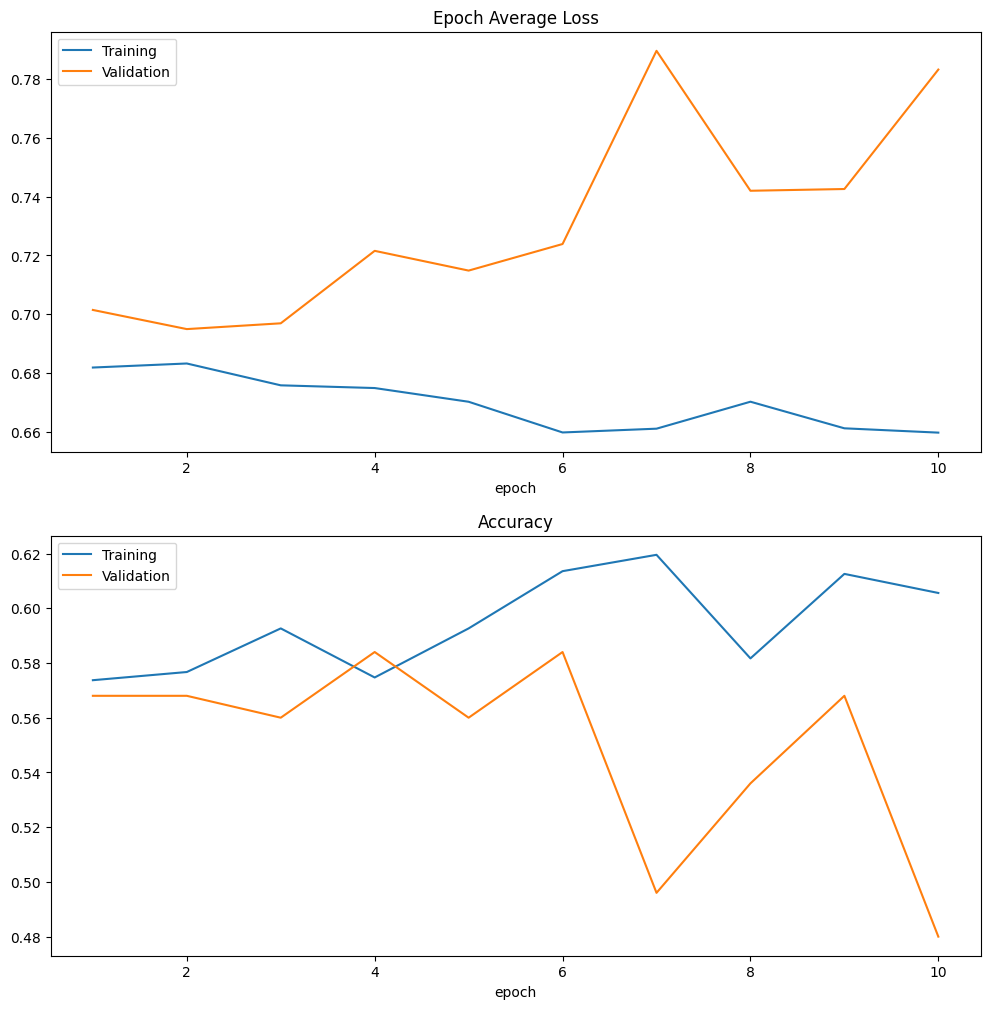

train completed, best_metric: 0.5840 at epoch: 4


In [13]:
val_interval = 1    # validate at every n epochs
graph_interval = 5    # plot training graphs every n epochs

best_metric = -1    # default value
best_metric_epoch = -1    # default value

# arrays to keep track of loss and accuracy for plotting curves
train_loss = []
val_loss = []
train_acc = []
val_acc = []


train_acc = []
val_acc = []

num_epochs = 10

for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    # Helper variables to calculate accuracy (num_correct / metric_count)
    # 1 - Class, 2 - Dimension, 3 - Orientation
    num_correct = 0.0
    metric_count = 0

    
    # TRAINING
    # using tqdm will show progress bar for each epoch
    with tqdm(train_loader, desc=("Epoch ")) as pbar:
        # iterate through train_loader batches
        for i, batch_data in enumerate(pbar):
            step += 1
            image, labels = torch.cat((batch_data["Flair_Image"].to(device, dtype=torch.float), batch_data["Flair_Mask_Image"].to(device, dtype=torch.float)), dim=1), torch.from_numpy(np.asarray(batch_data["MGMT"]).astype('int64')).to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()
            
            # values for calculating accuracy
            value = torch.eq(output.argmax(dim=1), labels)
            metric_count += len(value)
            num_correct += value.sum().item()                                                           

            
            # epoch loss
            epoch_loss += loss.item()
                                                                                      
            epoch_len = len(train_ds) // train_loader.batch_size
            
            # update progress bar to display loss
            pbar.set_postfix({'Overall Training Loss': loss.item()})
            
        # append loss and accuracy
        epoch_loss /= step
        train_loss.append(epoch_loss)
        metric = num_correct / metric_count
        train_acc.append(metric)
    
        # VALIDATION
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():

                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                                                                
                
                # iterate through valid_loader batches
                for i, val_data in enumerate(valid_loader):
                    val_flair, val_flair_mask, val_labels = val_data["Flair_Image"].to(device, dtype=torch.float), val_data["Flair_Mask_Image"].to(device, dtype=torch.float), torch.from_numpy(np.asarray(val_data["MGMT"]).astype('int64')).to(device)
                    output = model(torch.cat((val_flair, val_flair_mask), dim=1))
                    y_pred = torch.cat([y_pred, output], dim=0)
                    y = torch.cat([y, val_labels], dim=0)
                    
                # calculate and append loss
                loss = loss_function(y_pred, y)
                val_loss.append(loss.item())

                # calculate and append accuracy
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                val_acc.append(acc_metric)


                # update best metric
                if acc_metric > best_metric:
                    best_metric = acc_metric
                    best_metric_epoch = epoch + 1
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        'train_loss_arr': train_loss,
                        'val_loss_arr': val_loss,
                        'train_acc_arr': train_acc,
                        'val_acc_arr': val_acc,
                        'val_acc': val_acc,
                        'train_acc': train_acc,
                        }, "best_metric_resnet101.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current avg accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                        epoch + 1, acc_metric, best_metric, best_metric_epoch
                    )
                )
                print(
                    "train accuracy: {:.4f} validation accuracy: {:.4f} train loss: {:.4f} validation loss {:.4f}".format(
                        train_acc[-1], acc_metric, train_loss[-1],loss.item()
                    )
                )
                
        # display train/validation curves
        if (epoch + 1) % graph_interval == 0:
            plot_curves(train_loss, val_loss, train_acc, val_acc)
        
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

## 4. Evaluating Results

### 4.1 Evaluating the Model on the Test Dataset

In [17]:
saved_dict = torch.load("best_metric_resnet101.pth")
model.load_state_dict(saved_dict['model_state_dict'])
model.eval()
y_true = []
y_pred = []
y_probs = []


with tqdm(test_loader, desc=("Loading ")) as pbar:
    with torch.no_grad():
        for test_data in pbar:
            test_images, test_labels = (
                torch.cat((test_data["Flair_Image"].to(device, dtype=torch.float), test_data["Flair_Mask_Image"].to(device, dtype=torch.float)), dim=1), 
                torch.from_numpy(np.asarray(test_data["MGMT"]).astype('int64')).to(device)
            )
            pred = model(test_images)
            pred = pred.argmax(dim=1)
            output = model(test_images)
            probs = torch.nn.functional.softmax(output, dim=1)

            y_probs.extend(probs)

            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())


Loading : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:20<00:00,  1.55it/s]


#### 4.1.2 Classification Report

In [18]:

print(metrics.classification_report(y_true, y_pred, target_names=["UNMETHYLATED", "METHYLATED"], digits=4))

              precision    recall  f1-score   support

UNMETHYLATED     0.5926    0.8889    0.7111        72
  METHYLATED     0.5294    0.1698    0.2571        53

    accuracy                         0.5840       125
   macro avg     0.5610    0.5294    0.4841       125
weighted avg     0.5658    0.5840    0.5186       125



#### 4.1.3 Confusion Matrix

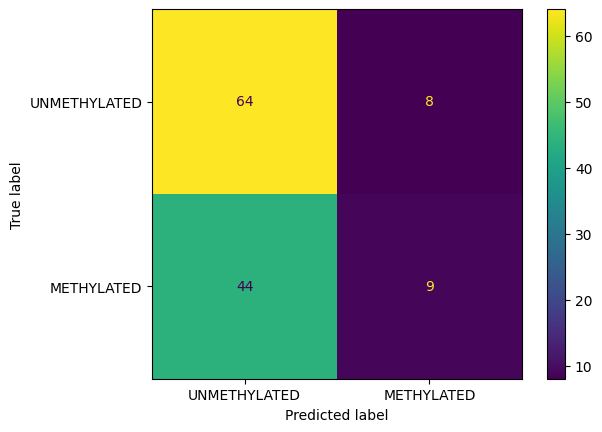

In [20]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["UNMETHYLATED", "METHYLATED"])
cm_display.plot()
plt.show()

In [ ]:
# This model is pretty much just guessing that everything is unmethylated right now... needs lots of work